# Постановка задачи

# Работа с данными

#### В июле провели специальную акцию, направленную на улучшение ретеншена. Новым юзерам слали письмо с купоном. Сработала ли акция?

#### сделать можно на питоне в юпитер или экселе или в гугл шите, даже можете в sql сделать, как удобнее.

#### Обратно нужно дать файл с формулами или кодом и описание того, как получился результат поэтапно.

#### user_id -  id пользователя
#### order_id - id заказа
#### reg_data - дата регистрации
#### transaction_date - дата покупки
#### revenue - полученный доход с пользователя

# Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
#анализ данных, загрузка датафрейм
import matplotlib.pyplot as plt
import seaborn as sns
#визуализация данных, отображение результатов

# Выгрузка данных

In [78]:
df = pd.read_csv('C:/Users/User/Downloads/analyst_test_transactions_db (1).csv')

In [79]:
df.head()

,user_id,order_id,reg_date,transaction_date,revenue
0,57562,94545.0,2013-12-22,2015-07-16,1088
1,40047,81824.0,2013-11-24,2015-01-19,1027
2,48153,144851.0,2015-07-03,2015-10-29,601
3,54591,116111.0,2013-07-12,2015-04-30,881
4,39789,134943.0,2013-05-25,2015-07-21,984


In [80]:
df.shape

(76857, 5)

In [81]:
df.describe()
# user_id < 0, order_id, дальнейшая проверка.
# revenue < 0, возможен возврат, надо смотреть по количеству

,user_id,order_id,revenue
count,76857.000000,76857.000000,76857.000000
mean,50112.561120,99950.627984,1000.587559
std,20051.576685,53283.741305,248.729287
min,-37599.000000,-138325.000000,-146.000000
25%,36575.000000,62909.000000,832.000000
50%,50145.000000,100145.000000,1001.000000
75%,63716.000000,136997.000000,1168.000000
max,138987.000000,305790.000000,2069.000000


In [82]:
df.isna().sum()
#пустых строк не было обнаружено

user_id             0
order_id            0
reg_date            0
transaction_date    0
revenue             0
dtype: int64

In [86]:
df['user_id'].nunique()
#уникальных юзеров - 48214

48214

In [87]:
df.dtypes
#дата - формата object - необходим перевод в datetime
#order_id - формата float, число с плавающей точкой

user_id               int64
order_id            float64
reg_date             object
transaction_date     object
revenue               int64
dtype: object

In [88]:
df['reg_date'].agg(['min','max'])
#минимальная дата при неприведенном типе относится к 1900 году, посмотрим на количество.

min    1900-01-01
max    2015-11-20
Name: reg_date, dtype: object

In [89]:
df['transaction_date'].agg(['min','max'])
#по дате транзакций видно, что информация представлена за 2015 год, нам нужно оценить эффект от купонов за 2015 год
#в июле вводится промоакция

min    2015-01-01
max    2015-11-20
Name: transaction_date, dtype: object

In [90]:
df[(df['reg_date'] >= '1900-01-01') & (df['reg_date'] < '2015-01-01')].shape

(42421, 5)

Видим, что значений, не относящихся к 2015 году - 42421.
В некоторых местах (где год = 1900) были выставлены стандартные значения ввиду отсутствия информации по дате регистрации.

In [91]:
df['order_id'].describe()
#заметим, что есть минимальное значение < 0, возможно здесь работал такой же принцип, как по дате регистрации.

count     76857.000000
mean      99950.627984
std       53283.741305
min     -138325.000000
25%       62909.000000
50%      100145.000000
75%      136997.000000
max      305790.000000
Name: order_id, dtype: float64

In [92]:
df[df['order_id'] < 0].shape
#таких данных - 2227.

(2227, 5)

Аналогично рассмотрим с user_id

In [93]:
df['user_id'].describe()

count     76857.000000
mean      50112.561120
std       20051.576685
min      -37599.000000
25%       36575.000000
50%       50145.000000
75%       63716.000000
max      138987.000000
Name: user_id, dtype: float64

In [94]:
df[df['user_id'] < 0].shape
#значений < 0 - 461

(461, 5)

Посмотрим сколько выручки было принесено с пользователей, чей id, order_id < 0

In [95]:
print(round(df[df['order_id'] <0]['revenue'].sum() / df['revenue'].sum(),5))
#составляет ~3% от общего значения revenue, можно принебречь

0.02897


In [96]:
print(round(df[df['user_id'] <0]['revenue'].sum() / df['revenue'].sum(),5))
#составляет меньше процента от общей выручки

0.00594


# Приведение типов значений

In [97]:
df.head()

,user_id,order_id,reg_date,transaction_date,revenue
0,57562,94545.0,2013-12-22,2015-07-16,1088
1,40047,81824.0,2013-11-24,2015-01-19,1027
2,48153,144851.0,2015-07-03,2015-10-29,601
3,54591,116111.0,2013-07-12,2015-04-30,881
4,39789,134943.0,2013-05-25,2015-07-21,984


In [98]:
df['reg_date'] = pd.to_datetime(df['reg_date'])
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['user_id'] = df['user_id'].apply(int)
df['order_id'] = df['order_id'].apply(int)

Отберем transaction_date при условии, что год покупки - 2015. 
1) отследим доход до июля 2017 года, потом после.
2) посмотрим на пользователей, которые встречаются в списке > 2 раз, выведем по ним информацию

In [104]:
count_order_id = df.groupby('user_id').agg({'order_id':'count', 'revenue':'sum'}).reset_index().rename(columns = ({'order_id':'count_order'}))
count_order_id.sort_values('revenue', ascending = False)

,user_id,count_order,revenue
21454,46832,9,9396
31827,60237,8,9069
27420,54441,8,8719
20461,45576,8,8565
22117,47671,8,8310
...,...,...,...
22330,47938,1,128
8632,28540,1,117
46306,88684,1,91
2271,12858,1,40


In [101]:
count_order_id['count_order'].value_counts()
#есть пользователи, которые оформляли заказ >2 раз

1    28901
2    12605
3     4739
4     1470
5      379
6       92
7       23
8        4
9        1
Name: count_order, dtype: int64

Посмотрим на распределение пользователей по количеству их заказов

<AxesSubplot:>

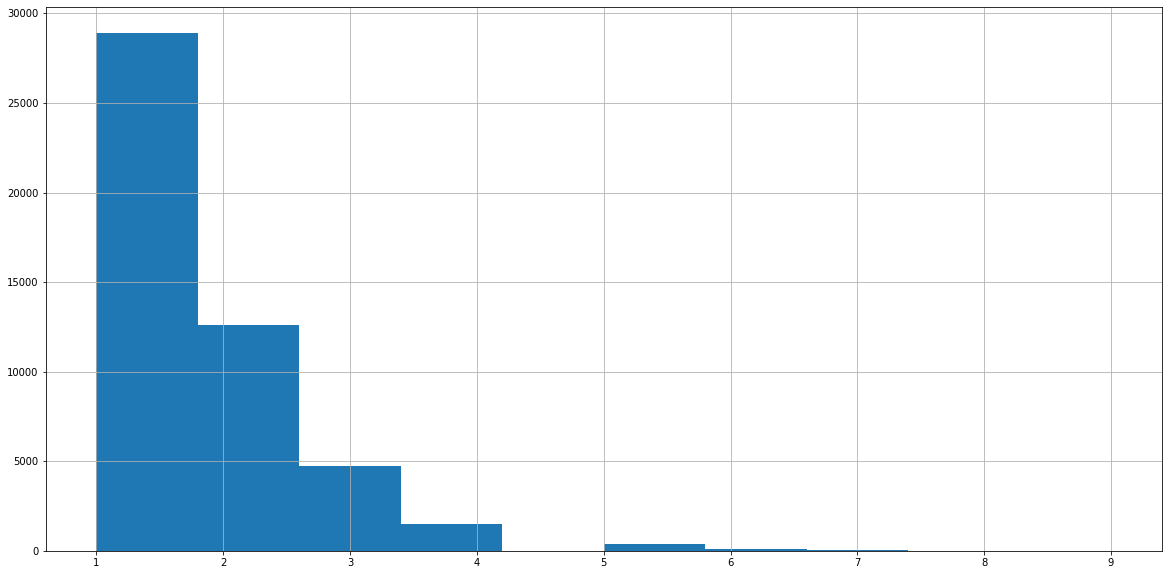

In [107]:
plt.figure(figsize = (20,10))
count_order_id['count_order'].hist()
#видим распределение с жирным хвостом, большая часть до 3-4 заказов

Так как нам нужно получить результаты за июль, выведем месяц регистрации и транзакции с соответствующим годом в отдельные столбцы

In [111]:
df['reg_month'] = df['reg_date'].dt.month
df['reg_year'] = df['reg_date'].dt.year
df['transaction_month'] = df['transaction_date'].dt.month
df['transaction_year'] = df['transaction_date'].dt.year

Выведем первый день месяца для того чтобы впоследствии можно было отследить количество пользователей

In [113]:
df['reg_first_day_month'] = df['reg_date'].astype('datetime64[M]')

In [117]:
df.head()

,user_id,order_id,reg_date,transaction_date,revenue,reg_month,reg_year,transaction_month,transaction_year,reg_first_day_month
0,57562,94545,2013-12-22,2015-07-16,1088,12,2013,7,2015,2013-12-01
1,40047,81824,2013-11-24,2015-01-19,1027,11,2013,1,2015,2013-11-01
2,48153,144851,2015-07-03,2015-10-29,601,7,2015,10,2015,2015-07-01
3,54591,116111,2013-07-12,2015-04-30,881,7,2013,4,2015,2013-07-01
4,39789,134943,2013-05-25,2015-07-21,984,5,2013,7,2015,2013-05-01


Посмотрим сколько пользователей пришло с каждого из месяцев, выведем количество уникальных, т.е. тех, кого не было до этого в списках по заказам

In [116]:
df.groupby('reg_first_day_month')['user_id'].agg(['count','nunique']).reset_index()

,reg_first_day_month,count,nunique
0,1900-01-01,53,53
1,2012-02-01,9,9
2,2012-03-01,362,361
3,2012-04-01,370,370
4,2012-05-01,301,301
5,2012-06-01,445,443
6,2012-07-01,370,369
7,2012-08-01,271,269
8,2012-09-01,356,355
9,2012-10-01,367,367


Аналогично сделаем с регистрациями, чтобы посмотреть на пользователей, которые приобрели продукт в тот или иной месяц конкретного года

In [120]:
df['transaction_first_day_month'] = df['transaction_date'].astype('datetime64[M]')
df.groupby('transaction_first_day_month')['user_id'].agg(['count','nunique']).reset_index()

,transaction_first_day_month,count,nunique
0,2015-01-01,4058,3951
1,2015-02-01,4932,4777
2,2015-03-01,5824,5599
3,2015-04-01,6102,5862
4,2015-05-01,6339,6063
5,2015-06-01,6829,6480
6,2015-07-01,7520,7166
7,2015-08-01,8598,8110
8,2015-09-01,8468,7964
9,2015-10-01,10492,9743


Определим первую дату регистрации каждого пользователя

In [145]:
user = df.groupby('user_id')['reg_first_day_month'].min().reset_index()

In [210]:
user

,user_id,reg_first_day_month,key
0,-37599,2015-01-01,1
1,-32239,2015-11-01,1
2,-29822,2015-07-01,1
3,-29531,2014-09-01,1
4,-25337,2015-04-01,1
...,...,...,...
48209,128964,2015-10-01,1
48210,130617,2015-02-01,1
48211,131071,2012-04-01,1
48212,132484,2015-06-01,1


Сгенерируем каждый месяц транзакций

In [146]:
min_date = df['transaction_first_day_month'].min()
max_date = df['transaction_first_day_month'].max()

In [147]:
month = pd.DataFrame(pd.date_range(min_date,max_date, freq = 'MS')).rename(columns = {0:'transaction_month'})

Для объединения user, month создадим ключ для дальнейшего cross-join'a по нему

In [148]:
user['key'] = 1
month['key'] = 1

In [149]:
template = user.merge(month, on = 'key')[['user_id','reg_first_day_month','transaction_month']]

In [150]:
len(template)

530354

In [153]:
template[template['transaction_month'] >= template['reg_first_day_month']]

,user_id,reg_first_day_month,transaction_month
0,-37599,2015-01-01,2015-01-01
1,-37599,2015-01-01,2015-02-01
2,-37599,2015-01-01,2015-03-01
3,-37599,2015-01-01,2015-04-01
4,-37599,2015-01-01,2015-05-01
...,...,...,...
530349,138987,2014-10-01,2015-07-01
530350,138987,2014-10-01,2015-08-01
530351,138987,2014-10-01,2015-09-01
530352,138987,2014-10-01,2015-10-01


In [154]:
df.head()

,user_id,order_id,reg_date,transaction_date,revenue,reg_month,reg_year,transaction_month,transaction_year,reg_first_day_month,transaction_first_day_month
0,57562,94545,2013-12-22,2015-07-16,1088,12,2013,7,2015,2013-12-01,2015-07-01
1,40047,81824,2013-11-24,2015-01-19,1027,11,2013,1,2015,2013-11-01,2015-01-01
2,48153,144851,2015-07-03,2015-10-29,601,7,2015,10,2015,2015-07-01,2015-10-01
3,54591,116111,2013-07-12,2015-04-30,881,7,2013,4,2015,2013-07-01,2015-04-01
4,39789,134943,2013-05-25,2015-07-21,984,5,2013,7,2015,2013-05-01,2015-07-01


Сагрегируем данные по айди пользователей и мессяцу/году транзакции

In [211]:
trans_month = df.groupby(['user_id','transaction_first_day_month']).revenue.sum().reset_index()

In [212]:
trans_month.columns = ['user_id','transaction_month','revenue']

In [213]:
trans_month

,user_id,transaction_month,revenue
0,-37599,2015-03-01,1182
1,-32239,2015-11-01,727
2,-29822,2015-09-01,908
3,-29531,2015-06-01,1462
4,-25337,2015-07-01,899
...,...,...,...
73027,128964,2015-10-01,1049
73028,130617,2015-06-01,1295
73029,131071,2015-10-01,856
73030,132484,2015-08-01,747


Создали информацию по всем месяцам активности, теперь при отсутствии каких-либо покупок у юзера будет выставлено в столбце Revenue - NaN, таким образом мы можем отследить юзеров в течение года

In [162]:
report = template.merge(trans_month, on = ['user_id','transaction_month'], how = 'left')

Пользователь активен в месяц тогда, когда у него Revenue > 0, создадим соответствующий столбец

In [164]:
report['active'] = report['revenue'] > 0 * 1

In [166]:
report.head()

,user_id,reg_first_day_month,transaction_month,revenue,active
0,-37599,2015-01-01,2015-01-01,NaN,False
1,-37599,2015-01-01,2015-02-01,NaN,False
2,-37599,2015-01-01,2015-03-01,1182.0,True
3,-37599,2015-01-01,2015-04-01,NaN,False
4,-37599,2015-01-01,2015-05-01,NaN,False


Создадим сводную таблицу для определения среднего значения Renention по месяцу, процент активных пользователей из всей когорты, отберем данные за 2015 год (по регистрации)

In [171]:
retention

transaction_month,2015-01-01,2015-02-01,2015-03-01,2015-04-01,2015-05-01,2015-06-01,2015-07-01,2015-08-01,2015-09-01,2015-10-01,2015-11-01
reg_first_day_month,,,,,,,,,,,
1900-01-01,0.150943,0.169811,0.339623,0.150943,0.169811,0.245283,0.113208,0.094340,0.094340,0.169811,0.094340
2012-02-01,0.111111,0.222222,0.111111,0.000000,0.444444,0.222222,0.222222,0.222222,0.222222,0.000000,0.222222
2012-03-01,0.146814,0.157895,0.124654,0.152355,0.146814,0.182825,0.168975,0.193906,0.177285,0.293629,0.160665
2012-04-01,0.146341,0.138211,0.230352,0.168022,0.168022,0.170732,0.170732,0.165312,0.176152,0.241192,0.178862
2012-05-01,0.097315,0.157718,0.167785,0.187919,0.187919,0.181208,0.177852,0.248322,0.174497,0.211409,0.181208
2012-06-01,0.116972,0.142202,0.146789,0.206422,0.172018,0.160550,0.162844,0.158257,0.197248,0.243119,0.176606
2012-07-01,0.136490,0.142061,0.153203,0.175487,0.167131,0.153203,0.181058,0.192201,0.147632,0.261838,0.186630
2012-08-01,0.079545,0.151515,0.185606,0.200758,0.151515,0.151515,0.193182,0.215909,0.204545,0.250000,0.189394
2012-09-01,0.156522,0.130435,0.153623,0.191304,0.165217,0.171014,0.144928,0.173913,0.165217,0.194203,0.144928


Посчитаем LifeTime пользователя, используя разницу между датой транзакции и регистрацией

In [183]:
report['lifetime'] = round((report.transaction_month
 - report.reg_first_day_month)/np.timedelta64(1, 'M'),0).astype('int')

In [199]:
report['lifetime'].describe()

count    530354.000000
mean         13.397727
std          46.845850
min         -10.000000
25%           3.000000
50%          10.000000
75%          20.000000
max        1390.000000
Name: lifetime, dtype: float64

Момент регистрации мог из-за кросс-джойна стать численно меньше по дате, чем регистрация. Поэтому дополнительно фильтруем

In [ ]:
report = report[report['lifetime'] >=0]

In [202]:
retention = report[report['reg_first_day_month'] >= '2015-01-01'].pivot_table(index = 'reg_first_day_month', 
                columns='lifetime', values = 'active', aggfunc = 'mean')

In [203]:
retention

lifetime,0,1,2,3,4,5,6,7,8,9,10
reg_first_day_month,,,,,,,,,,,
2015-01-01,0.116928,0.116056,0.129581,0.116492,0.115183,0.124782,0.118237,0.131326,0.126091,0.148778,0.114311
2015-02-01,0.132856,0.141543,0.135922,0.121615,0.122126,0.119571,0.123659,0.149208,0.163005,0.105263,NaN
2015-03-01,0.164114,0.138403,0.129650,0.127462,0.138403,0.145514,0.138950,0.170678,0.117068,NaN,NaN
2015-04-01,0.193627,0.158088,0.144608,0.136029,0.161152,0.137255,0.167892,0.127451,NaN,NaN,NaN
2015-05-01,0.246457,0.184252,0.154331,0.136220,0.152756,0.159055,0.132283,NaN,NaN,NaN,NaN
2015-06-01,0.257924,0.216283,0.180236,0.168428,0.189559,0.141703,NaN,NaN,NaN,NaN,NaN
2015-07-01,0.283110,0.331367,0.179088,0.181769,0.124397,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-01,0.423358,0.268613,0.222628,0.157664,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-01,0.429314,0.381497,0.221414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(159.0, 0.5, 'reg_month')

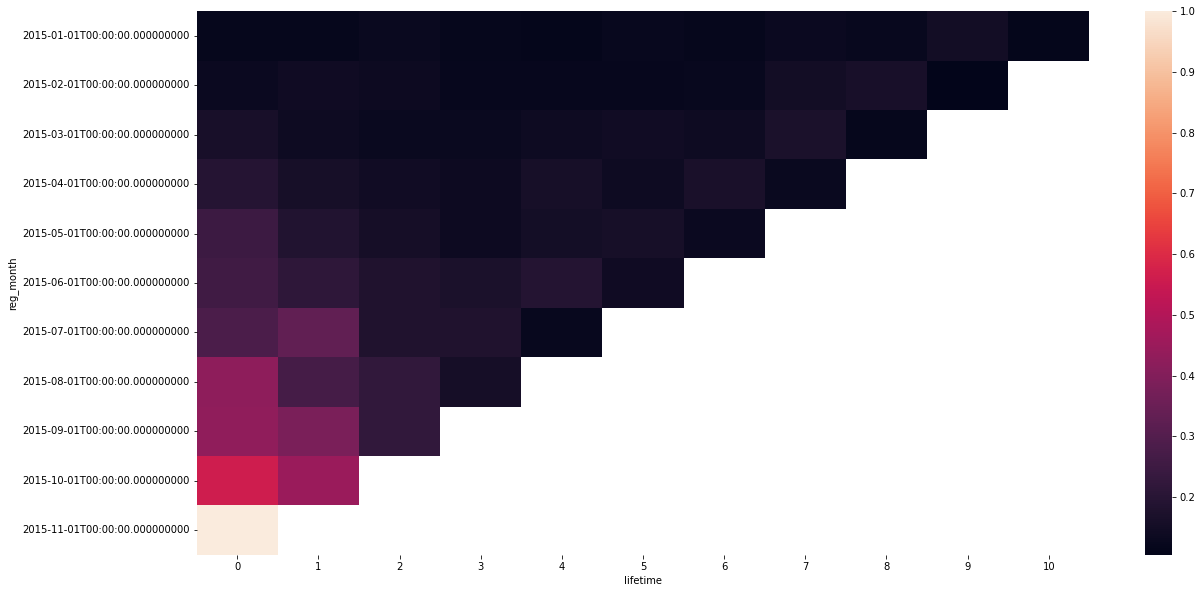

In [209]:
plt.figure(figsize = (20,10))
sns.heatmap(retention)
plt.xlabel('lifetime')
plt.ylabel('reg_month')

По heatmap видно, что с июля retention увеличился после июля - соответствующий цвет

Retention с 1-го месяца не равен 1 => пользователь мог зарегистрироваться и ничего не купить
Видно изменение у пользователей с 7 месяца и по следующим lifetime
Были замечены ошибки в исходных данных (отрицательные user_id), можно заметить, что они распределены нормально